This notebook demonstrates different approaches to adding environmental noise to simulated genetic values, either by specifying a narrow-sense heritability (h²) parameter that controls the genetic versus environmental contribution to variance, or by providing user-defined mean and standard deviation parameters for the noise distribution. The notebook systematically demonstrates these simulations both before and after normalizing genetic values, validates that the variance decomposition follows the expected h² relationship (where phenotypic variance equals genetic variance plus environmental variance), and visualizes the resulting distributions through histograms, ultimately showing how to export the final phenotype data to a standard .phen file format for downstream genetic analyses.

In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.phenotype import convert_to_phen

from test_phenotype_sim.phenotype_test import test_variance


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [-9.21868635e-01 -1.96238396e+00  6.99360161e-01 -1.72666426e+00
 -8.75593070e-01  4.50771668e-01  1.27471247e+00 -2.89765563e-01
 -1.02630152e+00 -6.18770396e-01 -2.22010640e+00 -2.23170896e+00
 -2.88249843e-01 -7.77635398e-02  1.54893324e+00 -1.00282258e+00
  1.54338967e+00 -4.69642192e-01 -2.60198740e-01 -2.58894696e-01
  1.47882140e+00  9.83802329e-01  3.63031041e-01 -1.11598438e-03
 -2.77457376e+00  4.78601411e-01  9.12269241e-02 -1.32278293e+00
  3.49910674e-01 -1.24476890e+00 -6.10346343e-01  8.93831355e-01
 -9.46522344e-02  7.51799500e-01 -5.81682253e-01 -7.59627160e-02
 -4.49543249e-01  2.19754537e-01 -4.41844011e-01 -5.27039463e-01
 -2.66421132e-01  4.73833464e-01 -4.54752105e-01 -9.37727548e-01
  4.49275381e-02  1.41894053e+00 -5.86019886e-02  8.71732506e-01
 -8.23668387e-01 -4.14085067e-02  4.59059453e-01  1.22366296e+00
  1.88204998e+00 -8.10019215e-01  4.61567537e-01  5.08261002e-01
 -1.13703743e+00 -3.93076756e-01  1.57497546e+00  6.93183808e-02
 

In [5]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)

In [6]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #non-normalized genetic value df
individual_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


We first show how to simulate environmental noise before the genetic values have been normalized, with a narrow-sense heritability of 0.5.

In [7]:
phenotypes = sim_env_noise(individual_genetic_value_df, h2=0.5) #simulating environmental noise without normalizing genetic values
phenotype_df = phenotypes.phenotype_df
phenotype_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,3.304577,-13.197087
1,0,1,-2.454348,17.496096,15.041748
2,0,2,-17.303803,-30.670053,-47.973856
3,0,3,6.641214,-14.230568,-7.589354
4,0,4,-8.710213,-16.660226,-25.370438
...,...,...,...,...,...
195,0,195,12.536488,-2.647439,9.889049
196,0,196,16.549154,4.276258,20.825412
197,0,197,5.463626,10.310793,15.774419
198,0,198,-0.663779,-6.191569,-6.855348


In [8]:
h2_used = phenotypes.get_h2() #showing the h2 factor used, can be acccessed since it is a class attribute of phenotypes
print(h2_used)

[0.5]


In [10]:
phenotype_df = normalize(phenotypes)
test1 = test_variance(phenotype_df)
print("Variance of the phenotypes is " + str(phenotype_df['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df['environmental_noise'].var()))
print(test1)   #tests the variance condition in the phenotypic data, expected value close to zero
phenotype_df

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.4871472013072092
Variance of the noise is 0.47376195369438845
0.03909084499840243


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.262131,0.220418,-0.041713
1,0,1,0.479069,0.969228,1.448297
2,0,2,-0.304456,-1.572239,-1.876694
3,0,3,0.958993,-0.704816,0.254177
4,0,4,0.148981,-0.833016,-0.684035
...,...,...,...,...,...
195,0,195,1.270054,-0.093637,1.176417
196,0,196,1.481781,0.271689,1.753470
197,0,197,0.896858,0.590098,1.486956
198,0,198,0.573548,-0.280642,0.292906


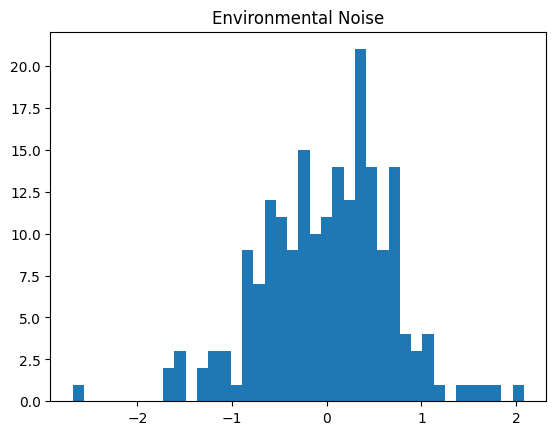

Mean of noise: 4.440892098500626e-18
Standard deviation of noise: 0.6883036783966714


In [11]:

plt.hist(phenotype_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df['environmental_noise'].std()))

Now, we show a sample where zero noise is simulated (h2=1) by default.

In [12]:
phenotypes_zero_noise = sim_env_noise(individual_genetic_value_df) #simulating environmental noise without normalizing genetic values
phenotype_df_zero_noise = phenotypes_zero_noise.phenotype_df
phenotype_df_zero_noise

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-16.501664
1,0,1,-2.454348,0.0,-2.454348
2,0,2,-17.303803,0.0,-17.303803
3,0,3,6.641214,0.0,6.641214
4,0,4,-8.710213,0.0,-8.710213
...,...,...,...,...,...
195,0,195,12.536488,0.0,12.536488
196,0,196,16.549154,0.0,16.549154
197,0,197,5.463626,0.0,5.463626
198,0,198,-0.663779,0.0,-0.663779


In [13]:
phenotype_df_zero_noise = normalize(phenotypes_zero_noise)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise['environmental_noise'].var()))
phenotype_df_zero_noise

Variance of the phenotypes is 1.0
Variance of the genetic values is 174.97473363027558
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-0.375568
1,0,1,-2.454348,0.0,0.686386
2,0,2,-17.303803,0.0,-0.436209
3,0,3,6.641214,0.0,1.373995
4,0,4,-8.710213,0.0,0.213453
...,...,...,...,...,...
195,0,195,12.536488,0.0,1.819668
196,0,196,16.549154,0.0,2.123019
197,0,197,5.463626,0.0,1.284972
198,0,198,-0.663779,0.0,0.821750


In [14]:
phenotype_df_zero_noise_genetic_normalize = normalize(phenotypes_zero_noise, normalize_genetic_values=True)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise_genetic_normalize['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise_genetic_normalize['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise_genetic_normalize['environmental_noise'].var()))
phenotype_df_zero_noise_genetic_normalize


Variance of the phenotypes is 1.0
Variance of the genetic values is 1.0
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.0,-0.375568
1,0,1,0.686386,0.0,0.686386
2,0,2,-0.436209,0.0,-0.436209
3,0,3,1.373995,0.0,1.373995
4,0,4,0.213453,0.0,0.213453
...,...,...,...,...,...
195,0,195,1.819668,0.0,1.819668
196,0,196,2.123019,0.0,2.123019
197,0,197,1.284972,0.0,1.284972
198,0,198,0.821750,0.0,0.821750


Now, we simulate environmental noise before the genetic values have been normalized, with user defined noise. If user_defined is set to True, the user must specify mean and std values to be simulated from.

In [15]:
phenotype_non_normalized_user_defined = sim_env_noise(individual_genetic_value_df, user_defined=True, mean=0, std=1) #simulating standard noise on the non-normalized genetic values
phenotype_df_non_normalized_user_defined = phenotype_non_normalized_user_defined.phenotype_df
phenotype_df_non_normalized_user_defined

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,2.398691,-14.102972
1,0,1,-2.454348,-0.608936,-3.063284
2,0,2,-17.303803,-0.216601,-17.520404
3,0,3,6.641214,2.407357,9.048570
4,0,4,-8.710213,-0.223614,-8.933827
...,...,...,...,...,...
195,0,195,12.536488,-0.879117,11.657371
196,0,196,16.549154,-0.368265,16.180890
197,0,197,5.463626,0.137097,5.600722
198,0,198,-0.663779,0.160115,-0.503664


The user can choose to view the h2 narrow sense heritability factor for the user-defined noise as well.

In [16]:
h2_user_defined = phenotype_non_normalized_user_defined.get_h2()
print(h2_user_defined)

1.0014767186420812


In [17]:
phenotype_df_non_normalized_user_defined = normalize(phenotype_non_normalized_user_defined)
print("Variance of the phenotypes is " + str(phenotype_df_non_normalized_user_defined['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_non_normalized_user_defined['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].var()))
phenotype_df_non_normalized_user_defined

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.9954884819920552
Variance of the noise is 0.005988236650026267


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.374720,0.185729,-0.188990
1,0,1,0.684836,-0.041129,0.643707
2,0,2,-0.435223,-0.011536,-0.446759
3,0,3,1.370892,0.186383,1.557275
4,0,4,0.212971,-0.012065,0.200906
...,...,...,...,...,...
195,0,195,1.815559,-0.061508,1.754051
196,0,196,2.118225,-0.022975,2.095249
197,0,197,1.282070,0.015143,1.297212
198,0,198,0.819894,0.016879,0.836773


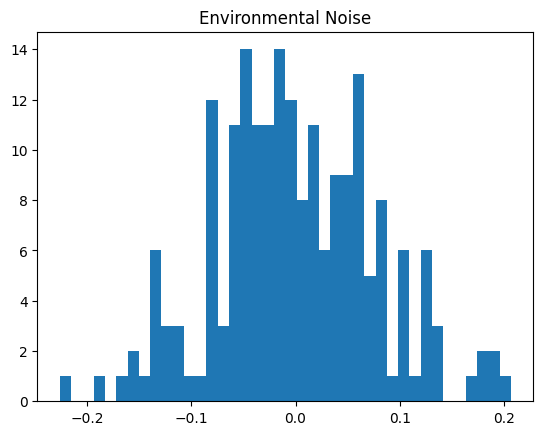

Mean of noise: -5.551115123125783e-19
Standard deviation of noise: 0.0773836975727205


In [18]:

plt.hist(phenotype_df_non_normalized_user_defined["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].std()))

The user could also define a custom distribution to simulate environmental noise from.

In [19]:
genetic_val_df_normalized = normalize_genetic_values(individual_genetic_value_df) #normalized genetic value df
genetic_val_df_normalized

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


We now show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 0.25.

In [20]:
phenotype_post_normalization_h2 = sim_env_noise(genetic_val_df_normalized, h2=0.25) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization_h2 = phenotype_post_normalization_h2.phenotype_df
phenotype_df_post_normalization_h2

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,-1.003053,-1.378621
1,0,1,0.686386,3.816919,4.503305
2,0,2,-0.436209,-1.927830,-2.364039
3,0,3,1.373995,0.069667,1.443662
4,0,4,0.213453,-3.324706,-3.111253
...,...,...,...,...,...
195,0,195,1.819668,-1.553511,0.266157
196,0,196,2.123019,-1.608704,0.514315
197,0,197,1.284972,-2.030753,-0.745781
198,0,198,0.821750,1.891726,2.713476


In [21]:
phenotype_df_post_normalization_h2 = normalize(phenotype_post_normalization_h2)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_h2['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_h2['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_h2['environmental_noise'].var()))
test3 = test_variance(phenotype_df_post_normalization_h2)
print(test3)  #tests the variance condition in the phenotypic data, expected value is close to zero
phenotype_df_post_normalization_h2

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.24745334155101165
Variance of the noise is 0.7701369913981039
-0.017590332949115384


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.186825,-0.494418,-0.681243
1,0,1,0.341440,1.903262,2.244702
2,0,2,-0.216991,-0.954445,-1.171436
3,0,3,0.683490,0.039203,0.722693
4,0,4,0.106181,-1.649317,-1.543135
...,...,...,...,...,...
195,0,195,0.905188,-0.768241,0.136947
196,0,196,1.056089,-0.795697,0.260392
197,0,197,0.639205,-1.005644,-0.366439
198,0,198,0.408777,0.945581,1.354358


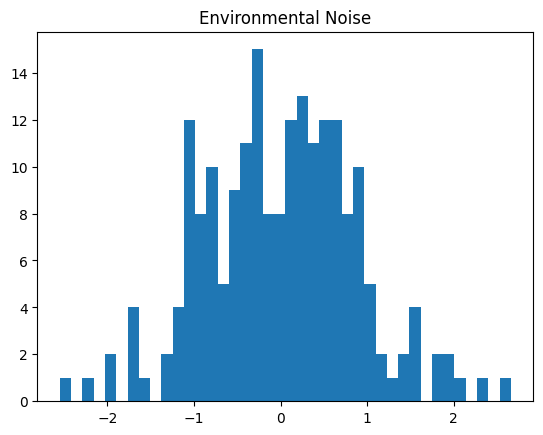

Mean of noise: 1.7763568394002505e-17
Standard deviation of noise: 0.8775744933611641


In [22]:

plt.hist(phenotype_df_post_normalization_h2["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].std()))

We finally show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 1 (default case) and user defined cases for the noise.

In [23]:
phenotype_post_normalization_default_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=0, std=1) #simulating noise after genetic values have been normalized with h2=1 and user defined with standard mean and std
phenotype_df_post_normalization_default_mean_and_std = phenotype_post_normalization_default_mean_and_std.phenotype_df
phenotype_df_post_normalization_default_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.609289,0.233720
1,0,1,0.686386,0.635739,1.322125
2,0,2,-0.436209,1.237600,0.801391
3,0,3,1.373995,0.592479,1.966474
4,0,4,0.213453,-0.623787,-0.410334
...,...,...,...,...,...
195,0,195,1.819668,-0.014715,1.804953
196,0,196,2.123019,-0.329275,1.793745
197,0,197,1.284972,-0.830247,0.454725
198,0,198,0.821750,-0.608661,0.213088


In [24]:
phenotype_df_post_normalization_default_mean_and_std = normalize(phenotype_post_normalization_default_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_default_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_default_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].var()))
phenotype_df_post_normalization_default_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.48633249043064497
Variance of the noise is 0.503568549399044


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.261912,0.397090,0.135178
1,0,1,0.478669,0.415536,0.894205
2,0,2,-0.304201,0.835259,0.531058
3,0,3,0.958191,0.385367,1.343558
4,0,4,0.148857,-0.462826,-0.313970
...,...,...,...,...,...
195,0,195,1.268992,-0.038075,1.230917
196,0,196,1.480541,-0.257441,1.223101
197,0,197,0.896108,-0.606807,0.289301
198,0,198,0.573068,-0.452278,0.120790


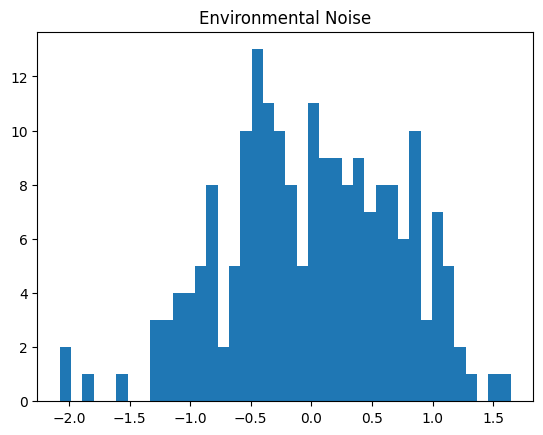

Mean of noise: -1.9984014443252817e-17
Standard deviation of noise: 0.7096256403196294


In [25]:

plt.hist(phenotype_df_post_normalization_default_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].std()))

In [26]:
phenotype_post_normalization_unique_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=1, std=2) #simulating noise after genetic values have been normalized with h2=1 and user defined mean and std
phenotype_df_post_normalization_unique_mean_and_std = phenotype_post_normalization_unique_mean_and_std.phenotype_df
phenotype_df_post_normalization_unique_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,1.182840,0.807272
1,0,1,0.686386,7.129013,7.815398
2,0,2,-0.436209,1.677961,1.241752
3,0,3,1.373995,4.172963,5.546958
4,0,4,0.213453,0.290653,0.504106
...,...,...,...,...,...
195,0,195,1.819668,1.490098,3.309767
196,0,196,2.123019,0.265951,2.388971
197,0,197,1.284972,1.523891,2.808863
198,0,198,0.821750,0.271164,1.092913


In [27]:
phenotype_df_post_normalization_unique_mean_and_std = normalize(phenotype_post_normalization_unique_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_unique_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_unique_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].var()))
test5 = test_variance(phenotype_df_post_normalization_unique_mean_and_std)
phenotype_df_post_normalization_unique_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.18712563622986958
Variance of the noise is 0.7928494795783229


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.162463,-0.043486,-0.205950
1,0,1,0.296917,2.528710,2.825627
2,0,2,-0.188695,0.170693,-0.018002
3,0,3,0.594363,1.249982,1.844345
4,0,4,0.092335,-0.429429,-0.337093
...,...,...,...,...,...
195,0,195,0.787153,0.089428,0.876580
196,0,196,0.918376,-0.440114,0.478262
197,0,197,0.555853,0.104046,0.659899
198,0,198,0.355473,-0.437860,-0.082387


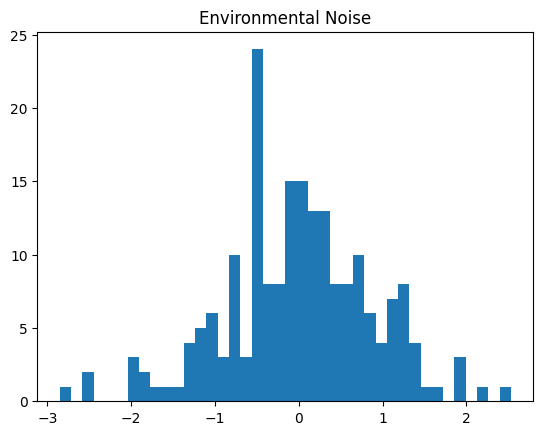

Mean of noise: -1.0436096431476471e-16
Standard deviation of noise: 0.8904209563899105


In [28]:

plt.hist(phenotype_df_post_normalization_unique_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].std()))

We show an example of converting the final phenotypes output to a standard .phen file format to be saved in the local directory.

In [29]:
local_path = 'post_noise_phenotypes.phen' #will be saved in a .phen file of this name in the local directory.
convert_to_phen(phenotype_df_post_normalization_unique_mean_and_std, local_path, include_header=True)